In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from root_numpy import root2array, root2rec, tree2rec, array2root
from ROOT import TFile
import matplotlib.mlab as mlab
from scipy.stats import norm

In [2]:
fname = 'NuEnergyReco_perfectreco_ana_out.root'
df = pd.DataFrame(root2array(fname,'tree'))

In [4]:
def gen_asym_data_for_bin(minE,maxE,n_prot_max=-1,n_secondary_prot_max=-1):
    #Query the entries in dataframe in this specific neutrino energy bin
    if n_prot_max == -1 and n_secondary_prot_max == -1:
        newdf = df.query('true_nu_E>%f and true_nu_E<%f'%(minE,maxE))
    elif n_prot_max == -1 and n_secondary_prot_max != -1:
        newdf = df.query('true_nu_E>%f and true_nu_E<%f and n_secondary_protons<=%d'%(minE,maxE,n_secondary_prot_max))
    elif n_prot_max != -1 and n_secondary_prot_max == -1:
        newdf = df.query('true_nu_E>%f and true_nu_E<%f and n_primary_protons<=%d'%(minE,maxE,n_prot_max))
    else:
        newdf = df.query('true_nu_E>%f and true_nu_E<%f and n_primary_protons<=%d and n_secondary_protons<=%d'%(minE,maxE,n_prot_max,n_secondary_prot_max))
    data = ((newdf['lep_E'] + newdf['tot_primaryprot_KE'] - newdf['true_nu_E'])/newdf['true_nu_E']).as_matrix()
    #Throw out data that is not in the range -1 to 1
    data = np.array([i for i in data if i <= 1 and i >= -1])
    return data

In [7]:
#Dict: key is (n_prot_max,n_secondary_prot_max) where -1 means any number
resolutions = { (-1,-1):[], (1,-1):[], (1,0):[] }

#Loop over energy bins and compute resolution in each bin. Make a plot.
E_bin_edges = np.array(range(0,3000,200))
fit_range = [-.5,.5]
for n_p, n_sp in resolutions.keys():
    for x in xrange(len(E_bin_edges)-1):
        data = gen_asym_data_for_bin(E_bin_edges[x],E_bin_edges[x+1],n_prot_max=n_p,n_secondary_prot_max=n_sp)
        mu,sigma = norm.fit([i for i in data if i >= fit_range[0] and i <= fit_range[1]])
        resolutions[(n_p,n_sp)].append(sigma)

(0, 0.2)

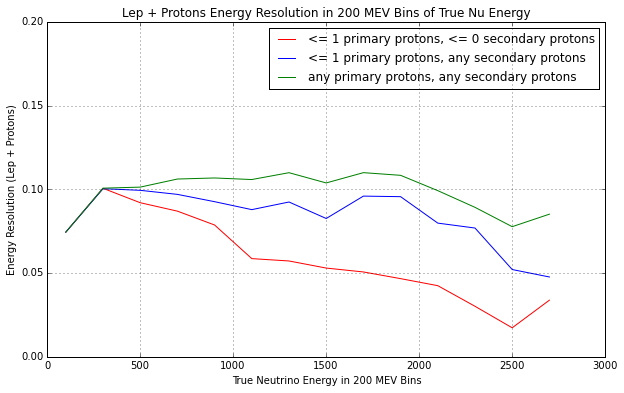

In [10]:
colors = ['c','m','y', 'k','g','b','r']
xvals = E_bin_edges[:-1] + (E_bin_edges[1]-E_bin_edges[0])/2.
plt.figure(figsize=[10,6])
plt.grid(True)

for n_p, n_sp in resolutions.keys():
    mylabel = '%s primary protons, %s secondary protons'%('any' if n_p < 0 else '<= %s'%n_p, 'any' if n_sp < 0 else '<= %s'%n_sp)
    plt.plot(xvals,resolutions[(n_p,n_sp)],'%s'%colors[-1],label=mylabel)
    del colors[-1]

plt.title('Lep + Protons Energy Resolution in 200 MEV Bins of True Nu Energy')
plt.legend()
plt.xlabel('True Neutrino Energy in 200 MEV Bins')
plt.ylabel('Energy Resolution (Lep + Protons)')
plt.ylim([0,.2])

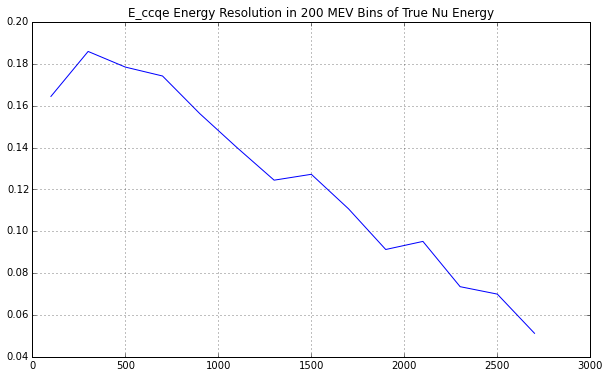

In [188]:
xvals = E_bin_edges[:-1] + (E_bin_edges[1]-E_bin_edges[0])/2.
plt.figure(figsize=[10,6])
plt.grid(True)
plt.plot(xvals,resolutions)
plt.title('E_ccqe Energy Resolution in 200 MEV Bins of True Nu Energy')

In [179]:
def draw_gauss(data,mu,sigma):
    #multiply normalized fit by bin_width*total_length_of_data
    plt.figure(figsize=[10,6])
    n,bins,patches = plt.hist(data,50,range=[-1,1])
    y = mlab.normpdf(bins,mu,sigma)*(bins[1]-bins[0])*(data.shape[0])
    plt.plot(bins,y,'r--',linewidth=2)
    plt.title('(E_ccqe - E_nu)/E_nu for Itxn == 1001, E_nu in a specific energy bin')
    plt.grid()

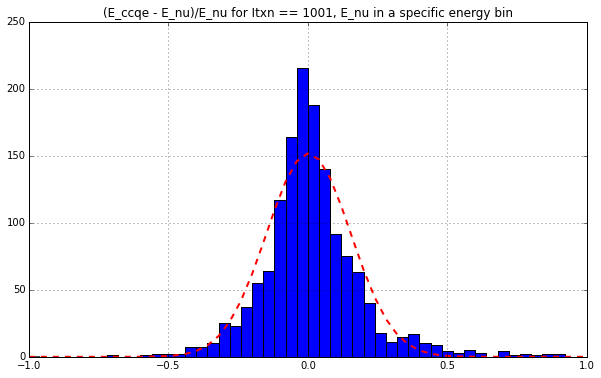

In [181]:
data = gen_asym_data_for_bin(800,1100)
mu,sigma = norm.fit([i for i in data if i >= fit_range[0] and i <= fit_range[1]])
draw_gauss(data,mu,sigma)